**Glass Identification Data Set**

**Scenario: Manufacturing identification for separabilitiy of classes.**
TN: wrangling
AK: model selection
BZ: 

Vina conducted a comparison test of her rule-based system, BEAGLE, the nearest-neighbor algorithm, and discriminant analysis. BEAGLE is a product available through VRS Consulting, Inc.; 4676 Admiralty Way, Suite 206; Marina Del Ray, CA 90292 (213) 827-7890 and FAX: -3189. In determining whether the glass was a type of "float" glass or not, the following results were obtained (# incorrect answers):

Type of Sample -- Beagle -- NN -- DA
Windows that were float processed (87) -- 10 -- 12 -- 21
Windows that were not: (76) -- 19 -- 16 -- 22

The study of classification of types of glass was motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence...if it is correctly identified!

Attribute Information:

1. Id number: 1 to 214
2. RI: refractive index
3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
4. Mg: Magnesium
5. Al: Aluminum
6. Si: Silicon
7. K: Potassium
8. Ca: Calcium
9. Ba: Barium
10. Fe: Iron
11. Type of glass: (class attribute)
-- 1 building_windows_float_processed
-- 2 building_windows_non_float_processed
-- 3 vehicle_windows_float_processed
-- 4 vehicle_windows_non_float_processed (none in this database)
-- 5 containers
-- 6 tableware
-- 7 headlamps


In [5]:
%matplotlib inline

import os
import json
import time
import pickle
import requests


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"

def fetch_data(fname='glass.csv'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data()

In [3]:
FEATURES  = [
    'id_number', 
    'ri', 
    'na', 
    'mg', 
    'al', 
    'si', 
    'k', 
    'ca', 
    'ba', 
    'fe', 
    'class'
]

CLASS_LABEL_MAP = {
    1: 'building_windows_float_processed' ,
    2: 'building_windows_non_float_processed' ,
    3: 'vehicle_windows_float_processed' ,
    4: 'vehicle_windows_non_float_processed' ,
    5: 'containers' ,
    6: 'tableware' ,
    7: 'headlamps' ,
}
                   
# Read the data into a DataFrame
df = pd.read_csv(DATA, header=None, names=FEATURES)

# Convert class labels into text
df['class'] = df['class'].map(CLASS_LABEL_MAP)

# Describe the dataset
print(df.describe(include='all'))

         id_number          ri          na          mg          al  \
count   214.000000  214.000000  214.000000  214.000000  214.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean    107.500000    1.518365   13.407850    2.684533    1.444907   
std      61.920648    0.003037    0.816604    1.442408    0.499270   
min       1.000000    1.511150   10.730000    0.000000    0.290000   
25%      54.250000    1.516523   12.907500    2.115000    1.190000   
50%     107.500000    1.517680   13.300000    3.480000    1.360000   
75%     160.750000    1.519157   13.825000    3.600000    1.630000   
max     214.000000    1.533930   17.380000    4.490000    3.500000   

                si           k          ca          ba          fe  \
count   214.000000  214.000000  214.000000  214.000000  214.000000   
unique         NaN 

In [4]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*df.shape))

# Determine the frequency of each class
print(pd.crosstab(index=df['class'], columns="count"))

214 instances with 11 features

col_0                                 count
class                                      
building_windows_float_processed         70
building_windows_non_float_processed     76
containers                               13
headlamps                                29
tableware                                 9
vehicle_windows_float_processed          17


In [7]:
from sklearn.datasets.base import Bunch

DATA_DIR = os.getcwd()

# Show the contents of the data directory
for name in os.listdir(DATA_DIR):
    if name.startswith("."): continue
    print("- {}".format(name))

- car.data
- car.names
- glass.csv
- glass.names
- glassmeta.json
- MLdemo_notes_07202019.ipynb
- uci_lab_07202019.ipynb
- uci_lab_winedata_07212019.ipynb
- uci_workshop_glass.ipynb
- Untitled.ipynb
- wine-knn-classifier.pickle
- wine-random-forest-classifier.pickle
- wine-svm-classifier.pickle
- wine.csv
- wine.data
- wine.names
- winemeta.json


In [26]:
def load_data(root=DATA_DIR):
    # Construct the `Bunch` for the glass dataset
    filenames     = {
        'meta': os.path.join(root, 'glassmeta.json'),
        'rdme': os.path.join(root, 'glass.names'),
        'data': os.path.join(root, 'glass.csv'),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = np.loadtxt(filenames['data'], delimiter = ",")

    # Extract the target from the data
    data   = dataset[:, 1:-1]
    target = dataset[:, -1]

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)
print(dataset.target.shape)

(214, 9)
(214,)


In [27]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    kf = KFold(n_splits = 12, shuffle=True)
    
    for train, test in kf.split(dataset.data):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))
    

In [28]:
# Perform kNN Classification
fit_and_evaluate(dataset, KNeighborsClassifier, "Glass kNN Classifier", n_neighbors=12)

Build and Validation of Glass kNN Classifier took 0.106 seconds
Validation scores are as follows:

precision    0.600146
recall       0.621460
accuracy     0.621460
f1           0.592721
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\XBUS-505-01.Data_Analysis_II_Machine_Learning\MLlab1\glass-knn-classifier.pickle


C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: Un

In [29]:
# Perform Random Forest Classification
fit_and_evaluate(dataset, RandomForestClassifier, "Glass Random Forest Classifier")

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\ensemble\forest

Build and Validation of Glass Random Forest Classifier took 0.494 seconds
Validation scores are as follows:

precision    0.748958
recall       0.739107
accuracy     0.739107
f1           0.728990
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\XBUS-505-01.Data_Analysis_II_Machine_Learning\MLlab1\glass-random-forest-classifier.pickle


C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [30]:
X  = df.drop(['id_number','class'], axis=1)
y = df['class']

C:\Users\akx00\Anaconda3\lib\site-packages\yellowbrick\features\rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()


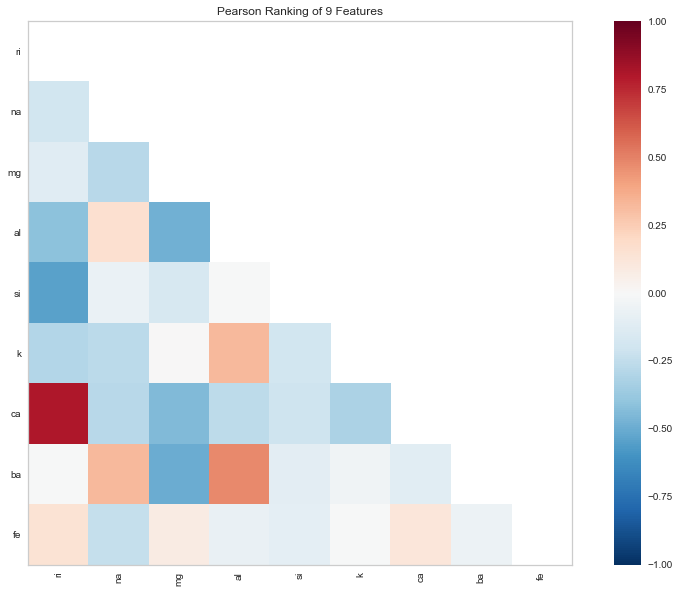

In [31]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()